In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from predictor import Predictor
from train_predictor import MaskPredDataset, MaskPredFormer, SampleVideoCallback
import matplotlib.pyplot as plt
import torch
import os
from tqdm import tqdm
import lightning as pl
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch.callbacks import ModelCheckpoint, LearningRateMonitor
from lightning.pytorch.tuner import Tuner
from lightning.pytorch.utilities import grad_norm

/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(


In [3]:
def visualize_seq(x):
    T, height, width = x.shape

    # Define the number of columns for the subplots
    num_columns = 3

    # Calculate the number of rows needed based on the number of columns
    num_rows = (T + num_columns - 1) // num_columns
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(12, 8))

    # Display each image in the tensor
    for i in range(num_rows*num_columns):
        row = i // num_columns
        col = i % num_columns
        ax = axes[row, col]
        if i < T:
            ax.imshow(x[i])
            ax.set_title(f"Image {i+1}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [4]:
train_set = MaskPredDataset("/scratch/me2646/dataset", "train", add_unlabeled=False)

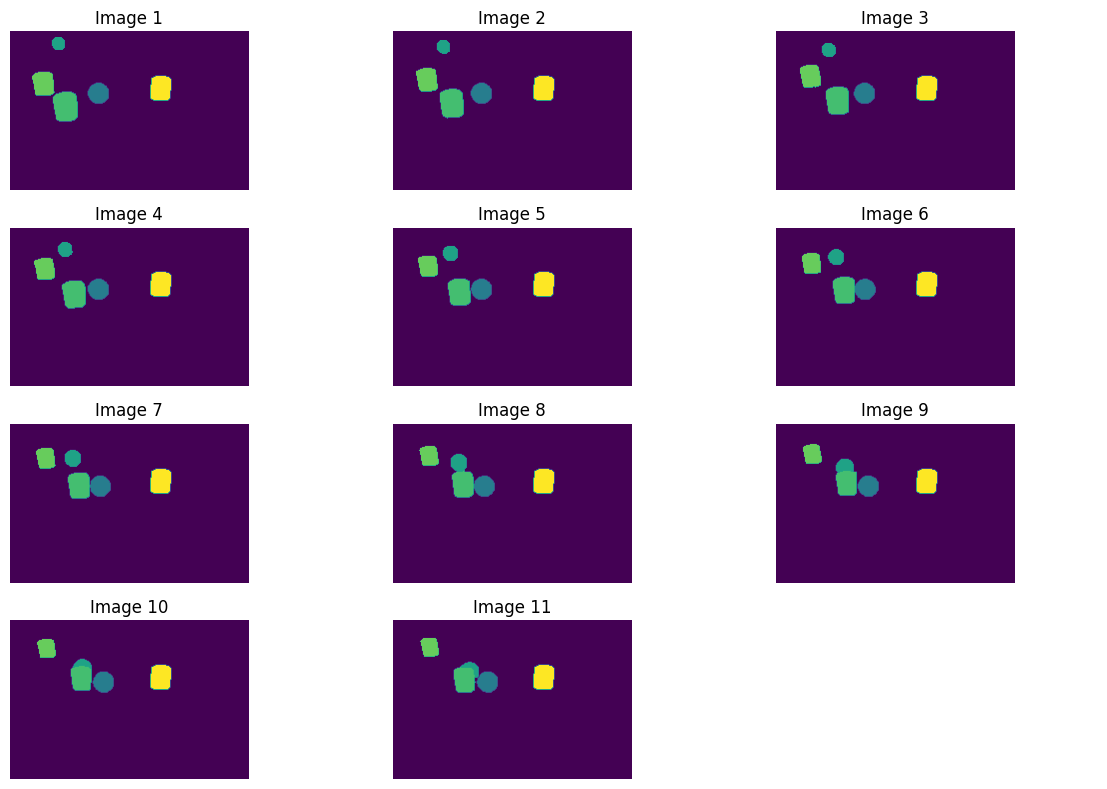

In [5]:
x, y= train_set[len(train_set)-1]
visualize_seq(x)

# Predictor

In [6]:
x, y = train_set[0]
x=x.unsqueeze(0)
y=y.unsqueeze(0)

In [7]:
predictor = Predictor()

In [8]:
predictor(x).shape

torch.Size([1, 11, 49, 160, 240])

# Dataset - get_video

In [9]:
vid = train_set.get_video(10)

# Train

In [10]:
pl.seed_everything(42)

[rank: 0] Seed set to 42


42

In [11]:
model = MaskPredFormer(data_root="/scratch/me2646/dataset", add_unlabeled=False, batch_size=4, lr=0.0005, max_epochs=10)

logger = WandbLogger(project="mask-predformer")
sample_video_cb = SampleVideoCallback(model.val_set)
checkpoint_callback = ModelCheckpoint(dirpath="models_train_only_small/", 
                                    filename='{epoch}-{val_loss:.3f}',
                                    monitor='val_loss', save_top_k=5, mode='min', save_last=True)
lr_monitor = LearningRateMonitor(logging_interval='step')
trainer = pl.Trainer(max_epochs=model.hparams.max_epochs, accelerator="gpu", logger=logger,
                     log_every_n_steps=50,
                     val_check_interval=0.3,
                     gradient_clip_val=0.5,
                    callbacks=[sample_video_cb, checkpoint_callback, lr_monitor])

/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [12]:
# tuner = Tuner(trainer)
# tuner.scale_batch_size(model)

In [13]:
# lr_finder = tuner.lr_find(model)
# # Results can be found in
# print(lr_finder.results)
# fig = lr_finder.plot(suggest=True)
# fig.show()
# plt.savefig("lr_finder.png")

In [ ]:
trainer.fit(
    model,
   
#     ckpt_path="models/last.ckpt"
)

wandb: Currently logged in as: eneserciyes. Use `wandb login --relogin` to force relogin


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type      | Params
----------------------------------------
0 | predictor | Predictor | 59.0 M
----------------------------------------
59.0 M    Trainable params
0         Non-trainable params
59.0 M    Total params
236.079   Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

INFO: Sampling validation videos


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Sampling validation videos


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Sampling validation videos


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Sampling validation videos


Validation: |          | 0/? [00:00<?, ?it/s]